In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, classification_report, mean_squared_error


In [2]:
import warnings
warnings.filterwarnings('ignore')

-------------------------------------
### 1. DATA LOADING AND MERGING
-------------------------------------

##### STEP 1: DATA LOADING AND MERGING

In [3]:
# Load all datasets
fertilizer_df = pd.read_csv('Fertilizer.csv')
crop_yield_df = pd.read_csv('crop_yield.csv')
rainfall_df = pd.read_csv('rainfall_validation.csv')
temperature_df = pd.read_csv('final_temperature.csv')

print("    - All datasets loaded.")
print(f"    - Fertilizer shape: {fertilizer_df.shape}")
print(f"    - Crop yield shape: {crop_yield_df.shape}")
print(f"    - Rainfall shape: {rainfall_df.shape}")
print(f"    - Temperature shape: {temperature_df.shape}")

    - All datasets loaded.
    - Fertilizer shape: (1843, 6)
    - Crop yield shape: (246091, 7)
    - Rainfall shape: (180, 14)
    - Temperature shape: (33, 5)


In [4]:
# Standardize text data function
def standardize_text(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().str.strip()
    return df


In [5]:
# Apply text standardization
crop_yield_df = standardize_text(crop_yield_df, ['State_Name', 'District_Name', 'Crop', 'Season'])
rainfall_df = standardize_text(rainfall_df, ['SUBDIVISION'])
temperature_df = standardize_text(temperature_df, ['States'])
fertilizer_df = standardize_text(fertilizer_df, ['Crop'])

print("    - Text data standardized (lowercase, stripped whitespace).")


    - Text data standardized (lowercase, stripped whitespace).


In [6]:
# State name mapping for consistency
state_name_mapping = {
    'andaman & nicobar islands': 'andaman and nicobar islands',
    'dadra & nagar haveli': 'dadra and nagar haveli',
    'jammu & kashmir': 'jammu and kashmir',
    'n.i. karnataka': 'north interior karnataka',
    's.i. karnataka': 'south interior karnataka',
    'rayalaseema': 'andhra pradesh',
    'coastal andhra pradesh': 'andhra pradesh',
    'telangana': 'andhra pradesh',
    'puducherry': 'pondicherry',
    'daman & diu': 'daman and diu',
    'uttaranchal': 'uttarakhand'
}

rainfall_df['SUBDIVISION'] = rainfall_df['SUBDIVISION'].replace(state_name_mapping)
temperature_df['States'] = temperature_df['States'].replace(state_name_mapping)

print("    - State names mapped for consistency.")


    - State names mapped for consistency.


In [7]:
# Process rainfall data
rainfall_df = rainfall_df.rename(columns={'SUBDIVISION': 'State_Name', 'YEAR': 'Crop_Year'})
rainfall_df['kharif_rainfall'] = rainfall_df[['JUN', 'JUL', 'AUG', 'SEP']].sum(axis=1)
rainfall_df['rabi_rainfall'] = rainfall_df[['OCT', 'NOV', 'DEC', 'JAN']].sum(axis=1)
rainfall_df['summer_rainfall'] = rainfall_df[['FEB', 'MAR', 'APR', 'MAY']].sum(axis=1)
rainfall_df['yearly_rainfall'] = rainfall_df.loc[:, 'JAN':'DEC'].sum(axis=1)

processed_rainfall_df = rainfall_df[['State_Name', 'Crop_Year', 'kharif_rainfall',
                                    'rabi_rainfall', 'summer_rainfall', 'yearly_rainfall']]

print("    - Rainfall data processed (seasonal/yearly sums calculated).")


    - Rainfall data processed (seasonal/yearly sums calculated).


In [8]:
# Merge datasets
df_merged = crop_yield_df.merge(processed_rainfall_df, on=['State_Name', 'Crop_Year'], how='left')
print(f"    - Shape after merging rainfall: {df_merged.shape}")

temperature_df = temperature_df.rename(columns={'States': 'State_Name'})
df_merged = df_merged.merge(temperature_df, on='State_Name', how='left')
print(f"    - Shape after merging temperature: {df_merged.shape}")

df_merged = df_merged.merge(fertilizer_df, on='Crop', how='left')
print(f"    - Shape after merging fertilizer: {df_merged.shape}")


    - Shape after merging rainfall: (248760, 11)
    - Shape after merging temperature: (261057, 15)
    - Shape after merging fertilizer: (1726005, 20)


In [9]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726005 entries, 0 to 1726004
Data columns (total 20 columns):
 #   Column           Dtype  
---  ------           -----  
 0   State_Name       object 
 1   District_Name    object 
 2   Crop_Year        int64  
 3   Season           object 
 4   Crop             object 
 5   Area             float64
 6   Production       float64
 7   kharif_rainfall  float64
 8   rabi_rainfall    float64
 9   summer_rainfall  float64
 10  yearly_rainfall  float64
 11  kharif_temp      float64
 12  rabi_temp        float64
 13  summer_temp      float64
 14  yearly_temp      float64
 15  Unnamed: 0       float64
 16  N                float64
 17  P                float64
 18  K                float64
 19  pH               float64
dtypes: float64(15), int64(1), object(4)
memory usage: 263.4+ MB


In [10]:
# If the column doesn't add value to your analysis
df_merged = df_merged.drop(columns=['Unnamed: 0'])

In [11]:
df_merged

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,yearly_rainfall,kharif_temp,rabi_temp,summer_temp,yearly_temp,N,P,K,pH
0,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,NaN,NaN,NaN,NaN,27.000000,26.60,27.8,27.036364,100.0,40.0,140.0,6.00
1,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,NaN,NaN,NaN,NaN,27.000000,26.60,27.8,27.036364,100.0,40.0,140.0,6.02
2,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,NaN,NaN,NaN,NaN,27.000000,26.60,27.8,27.036364,100.0,40.0,140.0,6.04
3,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,NaN,NaN,NaN,NaN,27.000000,26.60,27.8,27.036364,100.0,40.0,140.0,6.06
4,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,NaN,NaN,NaN,NaN,27.000000,26.60,27.8,27.036364,100.0,40.0,140.0,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726000,west bengal,purulia,2014,winter,rice,279151.0,597899.0,NaN,NaN,NaN,NaN,28.333333,22.28,29.2,25.818182,80.0,40.0,40.0,5.38
1726001,west bengal,purulia,2014,winter,rice,279151.0,597899.0,NaN,NaN,NaN,NaN,28.333333,22.28,29.2,25.818182,80.0,40.0,40.0,5.36
1726002,west bengal,purulia,2014,winter,rice,279151.0,597899.0,NaN,NaN,NaN,NaN,28.333333,22.28,29.2,25.818182,80.0,40.0,40.0,5.34
1726003,west bengal,purulia,2014,winter,rice,279151.0,597899.0,NaN,NaN,NaN,NaN,28.333333,22.28,29.2,25.818182,80.0,40.0,40.0,5.32


-------------------------------------
### 2. DATA QUALITY CHECKS AND CLEANING
-------------------------------------

##### STEP 2: DATA QUALITY CHECKS AND CLEANING

In [12]:
# Check for missing values
print("\nMissing values before cleaning:")
print(df_merged.isnull().sum())



Missing values before cleaning:
State_Name               0
District_Name            0
Crop_Year                0
Season                   0
Crop                     0
Area                     0
Production           18677
kharif_rainfall    1552997
rabi_rainfall      1552997
summer_rainfall    1552997
yearly_rainfall    1552997
kharif_temp          41031
rabi_temp            41031
summer_temp          41031
yearly_temp          41031
N                   179671
P                   179671
K                   179671
pH                  179671
dtype: int64


In [13]:
# Check for duplicates
print(f"\nNumber of duplicates: {df_merged.duplicated().sum()}")


Number of duplicates: 0


In [14]:
# Handle missing values
# For numerical columns, fill with grouped means
numerical_cols = ['Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                 'summer_rainfall', 'yearly_rainfall', 'kharif_temp',
                 'rabi_temp', 'summer_temp', 'yearly_temp', 'N', 'P', 'K', 'pH']

for col in numerical_cols:
    if col in df_merged.columns:
        if 'rainfall' in col:
            group_cols = ['State_Name', 'Crop_Year']
        elif 'temp' in col:
            group_cols = ['State_Name']
        elif col in ['N', 'P', 'K', 'pH']:
            group_cols = ['Crop']
        else:
            group_cols = ['State_Name', 'Crop', 'Season']

        df_merged[col] = df_merged[col].fillna(
            df_merged.groupby(group_cols)[col].transform('mean')
        )
        # Fill remaining with global mean
        df_merged[col] = df_merged[col].fillna(df_merged[col].mean())


In [15]:
# For categorical columns, fill with mode or 'unknown'
categorical_cols = ['State_Name', 'District_Name', 'Crop', 'Season']
for col in categorical_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(df_merged[col].mode()[0] if not df_merged[col].mode().empty else 'unknown')

print("\nMissing values after cleaning:")
print(df_merged.isnull().sum())



Missing values after cleaning:
State_Name         0
District_Name      0
Crop_Year          0
Season             0
Crop               0
Area               0
Production         0
kharif_rainfall    0
rabi_rainfall      0
summer_rainfall    0
yearly_rainfall    0
kharif_temp        0
rabi_temp          0
summer_temp        0
yearly_temp        0
N                  0
P                  0
K                  0
pH                 0
dtype: int64


In [16]:
# Remove duplicates if any
df_merged = df_merged.drop_duplicates()
print(f"\nNumber of duplicates after cleaning: {df_merged.duplicated().sum()}")



Number of duplicates after cleaning: 0


In [17]:
df_merged

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,yearly_rainfall,kharif_temp,rabi_temp,summer_temp,yearly_temp,N,P,K,pH
0,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,1233.963059,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.000000
1,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,1233.963059,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.020000
2,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,1233.963059,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.040000
3,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,1233.963059,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.060000
4,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,1233.963059,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.080000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726000,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,1233.963059,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.380000
1726001,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,1233.963059,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.360000
1726002,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,1233.963059,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.340000
1726003,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,1233.963059,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.320000


In [18]:
# Save intermediate merged data
df_initial_merged = df_merged

df_initial_merged.to_csv('agripredict_initial_merged_data.csv', index=False)
print("    - Intermediate merged data saved.")

    - Intermediate merged data saved.


-------------------------------------
### 3. FEATURE ENGINEERING
-------------------------------------

##### STEP 3: FEATURE ENGINEERING

In [19]:
# Create relevant rainfall and temperature based on season
conditions = [
    df_merged['Season'].str.contains('kharif'),
    df_merged['Season'].str.contains('rabi'),
    df_merged['Season'].str.contains('summer') | df_merged['Season'].str.contains('zaid'),
    df_merged['Season'].str.contains('whole year')
]

choices = [
    df_merged['kharif_rainfall'],
    df_merged['rabi_rainfall'],
    df_merged['summer_rainfall'],
    df_merged['yearly_rainfall']
]

df_merged['relevant_rainfall'] = np.select(conditions, choices, default=np.nan)

conditions_temp = [
    df_merged['Season'].str.contains('kharif'),
    df_merged['Season'].str.contains('rabi'),
    df_merged['Season'].str.contains('summer') | df_merged['Season'].str.contains('zaid'),
    df_merged['Season'].str.contains('whole year')
]

choices_temp = [
    df_merged['kharif_temp'],
    df_merged['rabi_temp'],
    df_merged['summer_temp'],
    df_merged['yearly_temp']
]

df_merged['relevant_temperature'] = np.select(conditions_temp, choices_temp, default=np.nan)

print("    - Created 'relevant_rainfall' and 'relevant_temperature' features.")



    - Created 'relevant_rainfall' and 'relevant_temperature' features.


In [20]:
df_merged

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,...,kharif_temp,rabi_temp,summer_temp,yearly_temp,N,P,K,pH,relevant_rainfall,relevant_temperature
0,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.000000,893.375234,27.0
1,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.020000,893.375234,27.0
2,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.040000,893.375234,27.0
3,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.060000,893.375234,27.0
4,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,27.000000,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.080000,893.375234,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726000,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.380000,NaN,NaN
1726001,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.360000,NaN,NaN
1726002,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.340000,NaN,NaN
1726003,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,28.333333,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.320000,NaN,NaN


In [21]:
# Calculate yield (production/area)
df_merged['Area'] = df_merged['Area'].replace(0, np.nan)
df_merged['Yield_ton_per_hec'] = df_merged['Production'] / df_merged['Area']
df_merged['Yield_ton_per_hec'] = df_merged['Yield_ton_per_hec'].replace([np.inf, -np.inf], np.nan)

# Fill yield NaNs with crop-season averages
df_merged['Yield_ton_per_hec'] = df_merged['Yield_ton_per_hec'].fillna(
    df_merged.groupby(['Crop', 'Season'])['Yield_ton_per_hec'].transform('mean'))
df_merged['Yield_ton_per_hec'] = df_merged['Yield_ton_per_hec'].fillna(df_merged['Yield_ton_per_hec'].mean())
print("    - Calculated 'Yield_ton_per_hec'.")


    - Calculated 'Yield_ton_per_hec'.


In [22]:
df_merged

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,...,rabi_temp,summer_temp,yearly_temp,N,P,K,pH,relevant_rainfall,relevant_temperature,Yield_ton_per_hec
0,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.000000,893.375234,27.0,1.594896
1,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.020000,893.375234,27.0,1.594896
2,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.040000,893.375234,27.0,1.594896
3,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.060000,893.375234,27.0,1.594896
4,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,26.60,27.8,27.036364,100.000000,40.000000,140.000000,6.080000,893.375234,27.0,1.594896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726000,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.380000,NaN,NaN,2.141848
1726001,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.360000,NaN,NaN,2.141848
1726002,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.340000,NaN,NaN,2.141848
1726003,west bengal,purulia,2014,winter,rice,279151.0,597899.0,893.375234,206.774431,133.813394,...,22.28,29.2,25.818182,80.000000,40.000000,40.000000,5.320000,NaN,NaN,2.141848


In [23]:
# Create interaction features
df_merged['rainfall_temp_interaction'] = df_merged['relevant_rainfall'] * df_merged['relevant_temperature']
df_merged['NPK_ratio'] = df_merged['N'] / (df_merged['P'] + df_merged['K'] + 1e-6)

print("    - Created interaction features.")

    - Created interaction features.


In [24]:
# Create lag features
df_merged = df_merged.sort_values(['State_Name', 'District_Name', 'Crop', 'Season', 'Crop_Year'])
df_merged['lagged_production_1yr'] = df_merged.groupby(['State_Name', 'District_Name', 'Crop', 'Season'])['Production'].shift(1)
df_merged['lagged_yield_1yr'] = df_merged.groupby(['State_Name', 'District_Name', 'Crop', 'Season'])['Yield_ton_per_hec'].shift(1)

# Fill lag features with mean values
df_merged['lagged_production_1yr'] = df_merged['lagged_production_1yr'].fillna(
    df_merged.groupby(['Crop', 'Season'])['lagged_production_1yr'].transform('mean'))
df_merged['lagged_yield_1yr'] = df_merged['lagged_yield_1yr'].fillna(
    df_merged.groupby(['Crop', 'Season'])['lagged_yield_1yr'].transform('mean'))

print("    - Created lag features.")

    - Created lag features.


In [25]:
# # # Create drought risk feature
# # df_merged['Drought_Risk'] = np.where(
# #     (df_merged['yearly_rainfall'] < 800) | (df_merged['Production'] < 1000), 1, 0)

# # print("    - Created 'Drought_Risk' feature.")

# # Final recommended version
# rain_thresh = df_merged['yearly_rainfall'].quantile(0.3)  # Adjust quantile as needed
# prod_thresh = df_merged['Production'].quantile(0.3)       # Adjust quantile as needed

# df_merged['Drought_Risk'] = np.where(
#     (df_merged['yearly_rainfall'] < rain_thresh) |
#     (df_merged['Production'] < prod_thresh), 1, 0)

# print("Final Drought Risk Distribution:")
# print(df_merged['Drought_Risk'].value_counts(normalize=True))

In [26]:
df_merged

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,...,P,K,pH,relevant_rainfall,relevant_temperature,Yield_ton_per_hec,rainfall_temp_interaction,NPK_ratio,lagged_production_1yr,lagged_yield_1yr
0,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,40.000000,140.000000,6.000000,893.375234,27.00,1.594896,24121.131321,0.555556,556.385935,1.475684
1,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,40.000000,140.000000,6.020000,893.375234,27.00,1.594896,24121.131321,0.555556,2000.000000,1.594896
2,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,40.000000,140.000000,6.040000,893.375234,27.00,1.594896,24121.131321,0.555556,2000.000000,1.594896
3,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,40.000000,140.000000,6.060000,893.375234,27.00,1.594896,24121.131321,0.555556,2000.000000,1.594896
4,andaman and nicobar islands,nicobars,2000,kharif,arecanut,1254.0,2000.0,893.375234,206.774431,133.813394,...,40.000000,140.000000,6.080000,893.375234,27.00,1.594896,24121.131321,0.555556,2000.000000,1.594896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725251,west bengal,purulia,2010,rabi,wheat,2013.0,5152.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,206.774431,22.28,2.559364,4606.934328,0.833949,2666.000000,1.613801
1725408,west bengal,purulia,2011,rabi,wheat,1880.0,4206.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,206.774431,22.28,2.237234,4606.934328,0.833949,5152.000000,2.559364
1725566,west bengal,purulia,2012,rabi,wheat,1648.0,3310.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,206.774431,22.28,2.008495,4606.934328,0.833949,4206.000000,2.237234
1725763,west bengal,purulia,2013,rabi,wheat,1187.0,2675.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,206.774431,22.28,2.253580,4606.934328,0.833949,3310.000000,2.008495


-------------------------------------
### 4. OUTLIER DETECTION AND TREATMENT
-------------------------------------

##### STEP 4: OUTLIER DETECTION AND TREATMENT

In [27]:
numerical_cols_for_outliers = ['Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                              'summer_rainfall', 'yearly_rainfall', 'kharif_temp',
                              'rabi_temp', 'summer_temp', 'yearly_temp', 'N', 'P', 'K',
                              'pH', 'Yield_ton_per_hec', 'rainfall_temp_interaction',
                              'NPK_ratio', 'lagged_production_1yr', 'lagged_yield_1yr']


In [28]:
def detect_outliers(df, col):
    """Detect and visualize outliers without modifying data"""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate outlier counts
    outliers_low = (df[col] < lower_bound).sum()
    outliers_high = (df[col] > upper_bound).sum()
    total_outliers = outliers_low + outliers_high
    pct_outliers = total_outliers / len(df) * 100

    # Create visualization
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col])
    plt.title(f'Outliers in {col}\n(Low: {outliers_low}, High: {outliers_high})')

    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True)
    plt.axvline(lower_bound, color='r', linestyle='--')
    plt.axvline(upper_bound, color='r', linestyle='--')
    plt.title(f'Distribution with Outlier Bounds\n({pct_outliers:.2f}% outliers)')
    plt.tight_layout()
    plt.show()

    return {
        'column': col,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_low': outliers_low,
        'outliers_high': outliers_high,
        'pct_outliers': pct_outliers
    }

In [29]:
def treat_outliers(df, col, lower_bound, upper_bound):
    """Treat outliers by capping at specified bounds"""
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                      np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df


Analyzing outliers for Area:


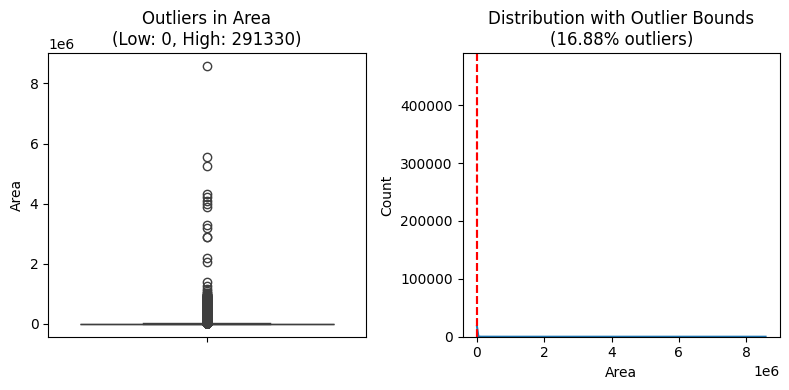

  - Lower bound: -8612.50
  - Upper bound: 14567.50
  - Low outliers: 0 (8.44%)
  - High outliers: 291330 (8.44%)
  - Total outliers: 291330 (16.88%)

Analyzing outliers for Production:


In [ ]:
# Step 1: Detect and analyze outliers
outlier_reports = []
for col in numerical_cols_for_outliers:
    if col in df_merged.columns:
        print(f"\nAnalyzing outliers for {col}:")
        report = detect_outliers(df_merged, col)
        outlier_reports.append(report)

        # Print summary statistics
        print(f"  - Lower bound: {report['lower_bound']:.2f}")
        print(f"  - Upper bound: {report['upper_bound']:.2f}")
        print(f"  - Low outliers: {report['outliers_low']} ({report['pct_outliers']/2:.2f}%)")
        print(f"  - High outliers: {report['outliers_high']} ({report['pct_outliers']/2:.2f}%)")
        print(f"  - Total outliers: {report['outliers_low'] + report['outliers_high']} ({report['pct_outliers']:.2f}%)")


In [ ]:
# Convert outlier reports to DataFrame for better visualization
outlier_df = pd.DataFrame(outlier_reports)
print("\nOutlier Summary Report:")
print(outlier_df[['column', 'outliers_low', 'outliers_high', 'pct_outliers']].sort_values('pct_outliers', ascending=False))


In [ ]:
# Step 2: Treat outliers after manual review

print("\nTreating outliers...")
for report in outlier_reports:
    col = report['column']
    lower = report['lower_bound']
    upper = report['upper_bound']
    df_merged = treat_outliers(df_merged, col, lower, upper)
    print(f"  - Capped outliers for {col} at [{lower:.2f}, {upper:.2f}]")


In [ ]:
# Step 3: Verify outlier treatment
print("\nVerifying outlier treatment...")
for col in numerical_cols_for_outliers:
    if col in df_merged.columns:
        min_val = df_merged[col].min()
        max_val = df_merged[col].max()
        print(f"  - {col} range after treatment: [{min_val:.2f}, {max_val:.2f}]")

-----------------------------------------
### 5. EXPLORATORY DATA ANALYSIS (EDA)
-----------------------------------------

##### STEP 5: EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
# 1. Distribution of numerical variables
numerical_cols_for_eda = ['Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                         'summer_rainfall', 'yearly_rainfall', 'kharif_temp',
                         'rabi_temp', 'summer_temp', 'yearly_temp', 'N', 'P', 'K',
                         'pH', 'Yield_ton_per_hec', 'rainfall_temp_interaction',
                         'NPK_ratio']

print("\n1. Distribution of Numerical Variables:")
for col in numerical_cols_for_eda:
    if col in df_merged.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df_merged[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.show()

In [ ]:
# 2. Categorical variable distributions
print("\n2. Distribution of Categorical Variables:")
categorical_cols_for_eda = ['State_Name', 'District_Name', 'Crop', 'Season']
for col in categorical_cols_for_eda:
    if col in df_merged.columns:
        plt.figure(figsize=(8, 4))
        if df_merged[col].nunique() > 10:  # For columns with many categories
            top_categories = df_merged[col].value_counts().nlargest(10).index
            sns.countplot(y=col, data=df_merged, order=top_categories)
        else:
            sns.countplot(x=col, data=df_merged)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
# 3. Correlation analysis
print("\n3. Correlation Analysis:")
plt.figure(figsize=(10, 6))
corr_matrix = df_merged[numerical_cols_for_eda].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

In [ ]:
# 4. Time series analysis of yield and production
print("\n4. Time Series Analysis:")
if 'Crop_Year' in df_merged.columns:
    yearly_summary = df_merged.groupby('Crop_Year').agg({
        'Production': 'sum',
        'Yield_ton_per_hec': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Crop_Year', y='Production', data=yearly_summary, marker='o')
    plt.title('Total Production Over Years')
    plt.xlabel('Year')
    plt.ylabel('Total Production')

    plt.subplot(1, 2, 2)
    sns.lineplot(x='Crop_Year', y='Yield_ton_per_hec', data=yearly_summary, marker='o', color='green')
    plt.title('Average Yield Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average Yield (ton/hec)')
    plt.tight_layout()
    plt.show()

In [ ]:
# 5. Relationship between key features and yield
print("\n5. Feature-Yield Relationships:")
key_features = ['relevant_rainfall', 'relevant_temperature', 'N', 'P', 'K', 'pH']
for feature in key_features:
    if feature in df_merged.columns:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=feature, y='Yield_ton_per_hec', data=df_merged, alpha=0.5)
        plt.title(f'Relationship between {feature} and Yield')
        plt.tight_layout()
        plt.show()

-----------------------------------------
### 6. FINAL PROCESSED DATA SAVE
-----------------------------------------

##### FINAL PROCESSED DATA SAVE

In [ ]:
# Select final columns to keep
final_columns = ['State_Name', 'District_Name', 'Crop', 'Season', 'Crop_Year',
                'Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                'summer_rainfall', 'yearly_rainfall', 'kharif_temp', 'rabi_temp',
                'summer_temp', 'yearly_temp', 'N', 'P', 'K', 'pH',
                'relevant_rainfall', 'relevant_temperature', 'rainfall_temp_interaction',
                'NPK_ratio', 'lagged_production_1yr', 'lagged_yield_1yr',
                'Yield_ton_per_hec']

df_final = df_merged[final_columns]

# Save final processed data
df_final.to_csv('agripredict_final_processed_data.csv', index=False)
print("    - Final processed data saved to 'agripredict_final_processed_data.csv'")

print("\n=== PROCESSING COMPLETE ===")

    - Final processed data saved to 'agripredict_final_processed_data.csv'

=== PROCESSING COMPLETE ===


In [ ]:
df_final

,State_Name,District_Name,Crop,Season,Crop_Year,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,...,K,pH,relevant_rainfall,relevant_temperature,rainfall_temp_interaction,NPK_ratio,lagged_production_1yr,lagged_yield_1yr,Yield_ton_per_hec,Drought_Risk
0,andaman and nicobar islands,nicobars,arecanut,kharif,2000,1254.0,2000.0,893.375234,206.774431,133.813394,...,117.500000,6.000000,893.375234,27.00,24121.131321,0.555556,556.385935,1.475684,1.594896,0
1,andaman and nicobar islands,nicobars,arecanut,kharif,2000,1254.0,2000.0,893.375234,206.774431,133.813394,...,117.500000,6.020000,893.375234,27.00,24121.131321,0.555556,2000.000000,1.594896,1.594896,0
2,andaman and nicobar islands,nicobars,arecanut,kharif,2000,1254.0,2000.0,893.375234,206.774431,133.813394,...,117.500000,6.040000,893.375234,27.00,24121.131321,0.555556,2000.000000,1.594896,1.594896,0
3,andaman and nicobar islands,nicobars,arecanut,kharif,2000,1254.0,2000.0,893.375234,206.774431,133.813394,...,117.500000,6.060000,893.375234,27.00,24121.131321,0.555556,2000.000000,1.594896,1.594896,0
4,andaman and nicobar islands,nicobars,arecanut,kharif,2000,1254.0,2000.0,893.375234,206.774431,133.813394,...,117.500000,6.070000,893.375234,27.00,24121.131321,0.555556,2000.000000,1.594896,1.594896,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725251,west bengal,purulia,wheat,rabi,2010,2013.0,5152.0,893.375234,206.774431,133.813394,...,53.883285,5.488273,206.774431,22.28,4606.934328,0.833949,2666.000000,1.613801,2.559364,0
1725408,west bengal,purulia,wheat,rabi,2011,1880.0,4206.0,893.375234,206.774431,133.813394,...,53.883285,5.488273,206.774431,22.28,4606.934328,0.833949,5152.000000,2.559364,2.237234,0
1725566,west bengal,purulia,wheat,rabi,2012,1648.0,3310.0,893.375234,206.774431,133.813394,...,53.883285,5.488273,206.774431,22.28,4606.934328,0.833949,4206.000000,2.237234,2.008495,0
1725763,west bengal,purulia,wheat,rabi,2013,1187.0,2675.0,893.375234,206.774431,133.813394,...,53.883285,5.488273,206.774431,22.28,4606.934328,0.833949,3310.000000,2.008495,2.253580,0
